# Fritsch Solition
Author: Joshua D. JOHN
Date: 2024/07/21

This is an implementation of Fritsch Solitons. What I am calling the Fritsch method is a way to create dark solitons at arbitrary position and velocity by simultaneously engineering the amplitude and phase of the condensate wave function. This is introduced as a better approach compared to the technique demonstrated before, which manipulated the condensate phase only.

* Fritsch, A.R., Lu, M., Reid, G., Piñeiro, A., & Spielman, I.B. (2020). _Creating solitons with controllable and near-zero velocity in Bose-Einstein condensates._ Physical review. A, 101 5.


In [1]:
from oqtant.schemas.quantum_matter import QuantumMatterFactory, QuantumMatter
from IPython.display import HTML
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d


qmf = QuantumMatterFactory()
qmf.get_login()

Auth(children=(HBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x12\x00\x00\x00\xc…

In [2]:
qmf.get_client()

Job Limits:
╒═══════════════╤═══════════════════╤════════════════════╤════════════════════╕
│   Daily Limit │   Daily Remaining │   Standard Credits │   Priority Credits │
╞═══════════════╪═══════════════════╪════════════════════╪════════════════════╡
│           100 │               100 │                100 │                 36 │
╘═══════════════╧═══════════════════╧════════════════════╧════════════════════╛


In [9]:
class FritschSoliton:
    def __init__(self, qmf, dimpling_potential = 0.5, imprinting_phase =1.0 , hold_time = 0):
        self.imprinting_phase = imprinting_phase
        self.dimpling_potential = dimpling_potential
        self.hold_time = hold_time
        
    def set_imprinting_phase(self, imprinting_phase):
        # validate imprinting phase
        self.imprinting_phase = imprinting_phase
        
    def set_dimpling_potential(self, dimpling_potential):
        self.dimpling_potential = dimpling_potential
        
    def set_hold_time(hold_time):
        self.hold_time = hold_time
    
        
    def get_matter(self):
        dV = self.dimpling_potential
        phV = self.imprinting_phase / 1.4 # U/h = phi/(2pi*t_p) t_p ~0.7ms
        dW = 3.0
        ramp_up = qmf.create_barrier(
            positions=[0, 0, 0],
            heights=[0, dV, 0],
            widths=[dW, dW, dW],
            times=[0, 15, 15.1],
            shape="GAUSSIAN",
        )

        # phase imprint ne snapshot
        positions = [-60, 0, 0, 60]
        heights_ramp = [0, 0, phV, phV]
        snapshot_zero = qmf.create_snapshot(
            time=15.2, positions=positions, potentials=heights_ramp, interpolation="LINEAR"
        )

        snapshot_one = qmf.create_snapshot(
            time=15.9,
            positions=[0, 0],
            potentials=[0, 0],
            interpolation="LINEAR",
        )
        phaser = qmf.create_landscape(snapshots=[snapshot_zero, snapshot_one])

        ramp_down = qmf.create_barrier(
            positions=[0, 0, 0],
            heights=[0, dV, 0],
            widths=[dW, dW, dW],
            times=[16.0, 16.1, 19.1],
            shape="GAUSSIAN",
        )
        
        fritsch_sol = qmf.create_quantum_matter(
            temperature=100,
            lifetime=80,
            time_of_flight=15,
            barriers=[ramp_up, ramp_down],
            landscape=phaser,
            name="fritsch_sol",
        )
        
        return fritsch_sol

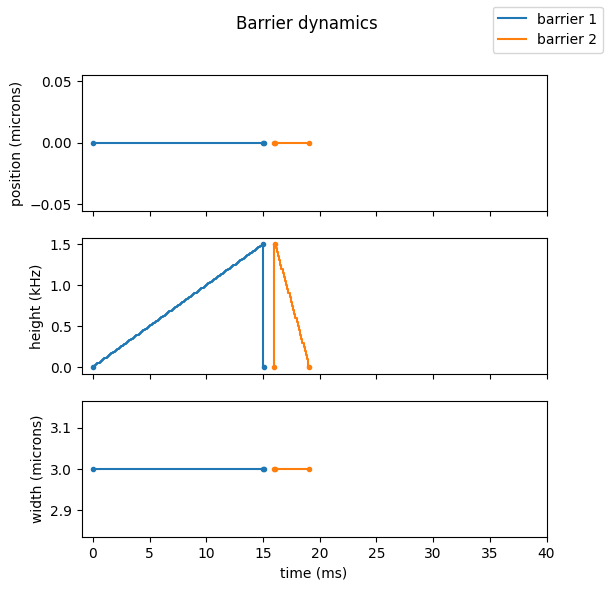

In [11]:
fs = FritschSoliton(qmf, 1.5)
fs_matter = fs.get_matter()
fs_matter.show_barrier_dynamics()